In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx

with open("data/news/data_lda_filtered.pkl", "rb") as file: data = pickle.load(file)
with open("data/news/df_gpt.pkl", "rb") as file: simulated_data = pickle.load(file)
n_noticias = len(data)
print("Cantidad de noticias: " + str(n_noticias))
print("Cantidad de comentarios: " + str(data.n_comentarios.sum()))

Cantidad de noticias: 117
Cantidad de comentarios: 11108


C:\Users\dimot\AppData\Local\Temp\ipykernel_11728\2347652076.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  with open("data/news/data_lda_filtered.pkl", "rb") as file: data = pickle.load(file)


In [4]:
simulated_data

,noticia,comentarios,categoria
0,Caso Audios: Tribunal accede a traslado de Lui...,"[(userE, Este caso claramente tiene muchas cap...",Nacional
1,"""Un peligro para la seguridad"": Los argumentos...","[(beta, Ya todos sabemos cómo termina esto… mu...",Nacional
2,"""Esto no ha terminado"": Fiscalía no descarta i...","[(beta, Es reconfortante ver señales de que la...",Nacional
3,"""No estamos de acuerdo"": Defensas de Hermosill...","[(userB, Esto no es más que una distracción pa...",Nacional
4,Boric valora prisión preventiva para Hermosill...,"[(userG, Siento que están magnificando todo es...",Nacional
5,De Santiago 1 a Capitán Yaber: Cuatro actos de...,"[(alpha, Esto envía una señal clara de que nad...",Nacional
6,Defensa de Hermosilla carga contra ministro Co...,"[(userC, Es evidente que todo esto no es más q...",Nacional
7,Ministros salen en defensa de Boric tras opini...,"[(userF, Esto solo parece una cortina de humo ...",Nacional
8,Caso Audios: Defensa de Hermosilla presenta re...,"[(userE, Esperemos que se aclare todo pronto y...",Nacional
9,Defensa de Hermosilla anuncia recurso en contr...,"[(userC, Es un desarrollo interesante de los a...",Nacional


#### Data GPT

In [14]:
simulated_data

users = []
for l in simulated_data["comentarios"]:
    for c in l:
        users.append(c[0])
users = list(set(users))
users_id = {j:i for i,j in enumerate(users)}
users = {i:j for i,j in enumerate(users)}

# Obtenemos la matriz de incidencia
incidence_matrix0 = np.zeros(shape=(len(users), len(simulated_data))) # (filas, columnas)
for index,row in simulated_data.iterrows():
    news_id = index
    for c in row["comentarios"]:
        user_id = users_id[c[0]]
        incidence_matrix0[(user_id, news_id)] = 1
        
# Obtenemos la cantidad de comentarios de cada usuario
user_n_comments = []
for i in users.keys():
    user_n_comments.append(incidence_matrix0[i].sum())
n_comments = np.array(user_n_comments)
valid_users = users.copy()
n_users = len(valid_users)
print("Cantidad de usuarios válidos: " + str(n_users))
# Recalculamos la matriz de incidencia sólo para los usuarios válidos
incidence_matrix = np.array([incidence_matrix0[i] for i in valid_users])

df = pd.DataFrame(incidence_matrix)
df.to_csv("created_data/simulated_incidence_matrix.csv", index=False)

Cantidad de usuarios válidos: 79


In [35]:
W = np.loadtxt("created_data/simulated_W.csv", delimiter=",", skiprows=1)
b = np.loadtxt("created_data/simulated_b.csv", delimiter=",", skiprows=1)

W_p = np.loadtxt("created_data/simulated_W_p_values.csv", delimiter=",", skiprows=1)
b_p = np.loadtxt("created_data/simulated_b_p_values.csv", delimiter=",", skiprows=1)

print("Cantidad de parámetros: " + str(len(W_p[W_p <= 0.99])))
print("Cantidad de parámetros significativos: " + str(len(W_p[W_p <= 0.05])))

for i in range(len(users)):
    if b_p[i]>0.05:
        b[i] = 0
    for j in range(len(users)):
        if W_p[i,j]>0.05:
            W[i,j] = 0

Cantidad de parámetros: 6140
Cantidad de parámetros significativos: 3672


In [131]:
import models
N = 10000
modes = []
best_mode = np.array([0]*len(users))
for aaa in range(N):
    vec = []
    for i in range(len(users)):
        vec.append(2*np.random.randint( low=0, high=2)-1)
    vec = np.array(vec)
    prob = models.fvbm_unnormalized_prob(vec,b,W)

    converged = False
    while not converged:
        converged = True
        for i in range(len(users)):
            vec1 = vec.copy()
            vec1[i] = -vec1[i]
            prob1 = models.fvbm_unnormalized_prob(vec1,b,W)
            if prob1 > prob:
                vec = vec1.copy()
                prob = prob1.copy()
                converged = False
    modes.append(vec)
    if prob > models.fvbm_unnormalized_prob(best_mode,b,W):
        best_mode = vec.copy()

In [132]:
for i in range(len(best_mode)):
    if best_mode[i] == 1:
        print(users[i])

user60
user26
user52
user37
user49
user32
user71
userA
user5
userF
user59
user74
user45
user34
alpha
user72
user61
user90
user64
user56
user113
user42
user35
user66
user40
user103
user33
user50
gamma
user78
user27
user89
user94
user51
user8
userC
user54
user68
user57
user13
user76
user17
userB
user48
user30
user55
user75
user53
user69
user70
userE
user88
user95
user15
user86


In [134]:
from collections import Counter

modes_count = Counter([tuple(arr.tolist()) for arr in modes])
max(dict(modes_count).values())

215

#### Data Real Pablo

In [2]:
# Obtenemos la lista de usuarios, y les asignamos un id numérico
users = []
for l in data["comentarios"]:
    for c in l:
        users.append(c[0])
users = list(set(users))
users_id = {j:i for i,j in enumerate(users)}
users = {i:j for i,j in enumerate(users)}

# Obtenemos la matriz de incidencia
incidence_matrix0 = np.zeros(shape=(len(users), len(data))) # (filas, columnas)
for index,row in data.iterrows():
    news_id = index
    for c in row["comentarios"]:
        user_id = users_id[c[0]]
        incidence_matrix0[(user_id, news_id)] = 1
        
# Obtenemos la cantidad de comentarios de cada usuario
user_n_comments = []
for i in users.keys():
    user_n_comments.append(incidence_matrix0[i].sum())
n_comments = np.array(user_n_comments)

# Nos quedamos sólo con los usuarios con más de X comentarios
valid_users_ids = []
for i in range(len(user_n_comments)):
    if user_n_comments[i]>= 10:
        valid_users_ids.append(i)
valid_users = {i:users[i] for i in valid_users_ids}
n_users = len(valid_users)
print("Cantidad de usuarios válidos: " + str(n_users))
# Recalculamos la matriz de incidencia sólo para los usuarios válidos
incidence_matrix = np.array([incidence_matrix0[i] for i in valid_users])

df = pd.DataFrame(incidence_matrix)
df.to_csv("created_data/incidence_matrix.csv", index=False)

Cantidad de usuarios válidos: 69


#### Bayesian Inference

In [3]:
import cmdstanpy
import os

X = incidence_matrix.copy()
X = (X*2-1).astype(int)

p,N = X.shape
prior_sd_w = 1
prior_sd_b = 1

cmdstanpy.write_stan_json("stan/data/fvbm-basic.json", {"p":p, "N":N, "X":X, "prior_sd_w":prior_sd_w, "prior_sd_b":prior_sd_b})

In [4]:
import cmdstanpy

stan_model = cmdstanpy.CmdStanModel(stan_file=os.path.join("stan", "models",'fvbm-basic.stan'), force_compile=True
                                    )

fit = stan_model.sample(
    data="stan/data/fvbm-basic.json",
    chains=4,
    iter_sampling=1500,
    iter_warmup=500, 
    seed=12345, #show_console=True
)

13:43:43 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan\models\fvbm-basic.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan\models\fvbm-basic.exe
13:43:54 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\stan\models\fvbm-basic.exe
13:43:54 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
13:43:54 - cmdstanpy - WARNING - "cut" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"cut" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
process_begin: CreateProcess(NULL, expr >= 8, ...) failed.
mingw32-make: makefile:124: pipe: Bad file descriptor
El sistema no puede encontrar el archivo especificado.
El sistema no puede encontrar la ruta especificada.
''
'--- Translating Stan model to C++ code ---'
bin/stanc.exe --filename-in-msg=fvbm-basic.stan --o=C:/Users/dimot/Documents/Universi

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:40:53 - cmdstanpy - INFO - CmdStan done processing.


In [5]:
fit.save_csvfiles("stan/fitted/fvbm-basic.csv")

In [6]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [1]:
import cmdstanpy

fit = cmdstanpy.from_csv("stan/fitted/fvbm-basic.csv")

In [ ]:
b = fit.b

for i in range( b.T.shape[0]):
    print(b[i].mean())

-0.5209970492753623
-0.5638604002898551
-0.45882832028985504
-0.6133315101449277
-0.502990305942029
-0.56921486
-0.4236799434782608
-0.5373902681159419
-0.48346062173913057
-0.48700702028985504
-0.44164527971014494
-0.49702737971014493
-0.45251590449275364
-0.609520784057971
-0.5171888173913044
-0.5470657376811594
-0.4844402275362319
-0.5788265913043479
-0.5495278840579709
-0.495941358405797
-0.6444728086956522
-0.47965694559420285
-0.4163046231884057
-0.5015046144927535
-0.5521023088405798
-0.4169893043478261
-0.5377349314492754
-0.6189084127536232
-0.4760275262463768
-0.5505882985507247
-0.4688199231884058
-0.5793842652173912
-0.5253022028985508
-0.530178249826087
-0.49244180420289857
-0.5108714014492755
-0.6697431755072465
-0.697136211594203
-0.4846219040579709
-0.5420433275362319
-0.5755874057971014
-0.5736408000000001
-0.5764428211594202
-0.5597556794202899
-0.5774896144927535
-0.4997983057971015
-0.663257115942029
-0.38290194347826084
-0.5744237202898551
-0.7416611623188405
-0.30

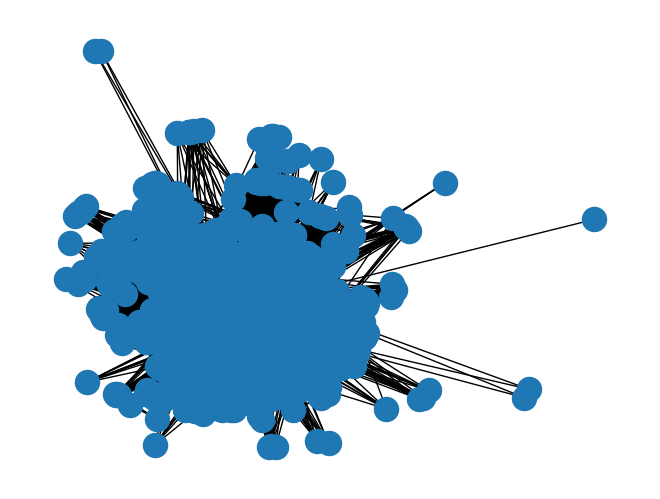

In [ ]:
am = (np.dot(incidence_matrix0, incidence_matrix0.T) > 0).astype(int)
np.fill_diagonal(am, 0)
G = nx.from_numpy_array(am)

nx.draw(G)